## Relevant Imports ##


In [9]:
import atlite
import numpy as np
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import hvplot.pandas
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject
hvplot.extension('matplotlib')

## Path Imports ##

In [10]:
#Include own data paths
ks = "NUTS_RG_10M_2021_4326.geojson" # complete Nuts data set, possible to choose a smaller regio
nuts = gpd.read_file(ks).to_crs(3035)

shape_path = "leeste3035.gpkg" 

built_area_path = "IBU_2018_010m_eu_03035_V1_0.tif" 
demand_path = "Last_240222.csv"
cop_path = "COP_WP.xlsx"


# Define the path for the ERA5 cutout data to be saved to
era5_cutout_path = "era5-2014-leeste.nc"

## Preparatory Work ##

### Creating usable Shape variable based on the Shape file and setting up atlite exclusion container ###

In [11]:
# Loading the relevant shape file of the region
shape = gpd.read_file(shape_path).to_crs(3035)
shap e= shape.set_index('Name')


# Define exclusion container for built areas
buildings_excluder = atlite.ExclusionContainer(crs=3035, res=10)
buildings_excluder.add_raster(built_area_path, crs=3035, codes=1, invert=True)

# Define the geographical area of interest for Weather cutout
minx , miny, maxx, maxy = nuts.total_bounds
buffer = 0.005
x_slice = slice(minx - buffer, maxx + buffer)
y_slice = slice(miny - buffer, maxy + buffer)

### Reading and Preparing Load/Demand Data ###

In [12]:
load= pd.read_csv(demand_path)
# Data Specific preparations, Adjust according to own Data
seconds_offset = (2014 - 1970) * 365.25 * 24 * 3600
load.iloc[:,0]=pd.to_datetime(load.iloc[:,0]+ seconds_offset, unit='s')
load=load.drop(load.tail(4).index)

load = load.set_index(load.columns[0])
load.iloc[:,:] 
load = load.apply(pd.to_numeric, errors='coerce')
load_dhw = load["ABS III_Q_flow_dhw/kW"]
load_sph = load["ABS III_Q_flow_sph/kW"]

#Conversion from kW to MW
load_dhw.iloc[:] /= 1000 
load_sph.iloc[:] /= 1000


### Reading COP Values from Excel file, preparing Data ###

In [13]:
COP = pd.read_excel(cop_path)
# Data Data Specific preparations, Adjust according to own Data
seconds_offset = (2014 - 1970) * 365.25 * 24 * 3600
hours_offset = (2014 - 1970) * 365.25 * 24
COP.iloc[:,0]=pd.to_datetime(COP.iloc[:,0]+ hours_offset, unit='h')
COP = COP.set_index(COP.columns[0])
COP.drop(COP.tail(2).index,
        inplace = True)

COP = COP["WP_L"]

### Creating atlite cutout with weather data ###


In [14]:
# Load the ERA5 cutout data for the defined geographical area
cutout = atlite.Cutout(
    path=era5_cutout_path,
    module="era5",
    x=x_slice,
    y=y_slice,
    time="2014",  
    weather=True
)


##run if no era5.nc file exists
#cutout.prepare()



/home/karimshawky/anaconda3/envs/esm-2023/lib/python3.11/site-packages/atlite/cutout.py:185: UserWarning: Arguments module, x, y, time, weather are ignored, since cutout is already built.
  warn(


### Setting up Availability Matrix for the defined Region ###

In [15]:
# Calculate the availability matrix for CSP
A = cutout.availabilitymatrix(shape, buildings_excluder)

cap_per_sqkm = 8 # MW/km2
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
capacity_matrix = A.stack(spatial=['y', 'x']) * area * cap_per_sqkm


band, transform = atlite.gis.shape_availability(shape.geometry, buildings_excluder)

fig, ax = plt.subplots(figsize=(8, 8))
shape.plot(ax=ax, color='none')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Northings (m)')
rio.plot.show( band, transform=transform, cmap='Greens', ax=ax) 


#plt.savefig("availableArea.png", dpi=400)

Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  4.11 gridcells/s]


### Setting up the Concetrated Solar Power (CSP) Data from the atlite calculation (of parabolic trough system) and the ERA5 cutout

In [17]:
# Initialize an empty array to store CSP potential for each month
csp_potential_year = []

# Loop over each month in the year
csp_potential_year = cutout.csp(
    installation="lossless_installation",
    technology="parabolic trough",
    index= shape.index,
    matrix=capacity_matrix,
)

### Converting the Parabolic trough CSP values to Flate plate Solar Thermal Values using the effiency ratio ###

In [18]:
# Convert the list of DataArrays to a single DataArray along the time dimension
csp_potential_year = xr.concat(csp_potential_year, dim='time')
# efficency ratio for 500 W/m^2 25/60, 1000W/m2 ratio 50/65
st_potential = csp_potential_year.sum(dim=['Name'])*(25/60)
st_potential = st_potential.to_pandas()


# Total coverage of Load based on Potential in % 
print(st_potential.sum()/load_dhw.sum()*100)

26.008799858060417


### Creating a Potential PV Power output based on the exclusion data (Shape file) and the weather data (ERA5 Cutout) ###

In [19]:
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix,
    orientation='latitude_optimal',
    index=shape.index,
    #per_unit=True
    )
pv = pv.to_pandas()
pv = pv["LeesteFull"]
# Total coverage of Load based on Potential in % 
print(pv.sum()/load["ABS III_Q_flow_sph/kW"].sum()*100)


14.510471591207343


### Multiplying the hourly PV potential with the hourly COP values of Air Heat pumps (based on fluctuating ambient temperatures) ###

In [20]:
HP = pv*COP

## Plotting ##

### Plot the CSP potential ###

:Curve   [time]   (0)
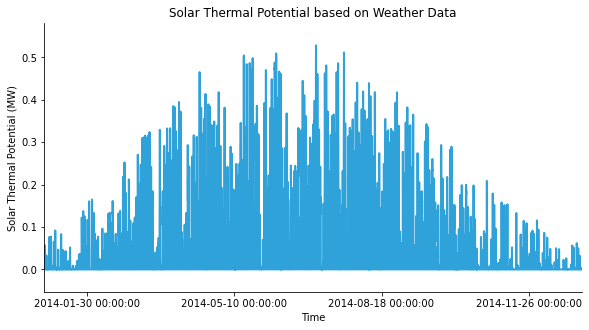

In [21]:
st_potential.hvplot.line( line_width=2, width=800, height=400, xlabel='Time', ylabel='Solar Thermal Potential (MW)', title= "Solar Thermal Potential based on Weather Data", xticks=4)

### Plottling Domestic Hot Water (DHW) Load from Simulated results ###

:Curve   [Time/s]   (ABS III_Q_flow_dhw/kW)
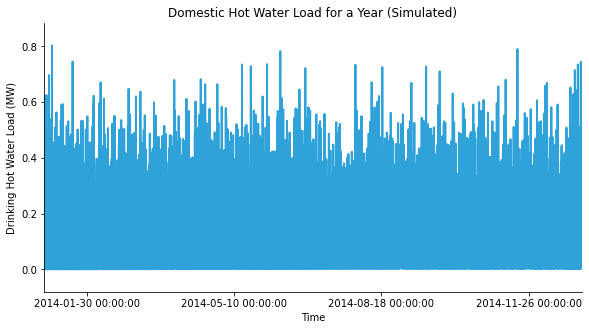

In [22]:
load_dhw.hvplot.line(line_width=2, width=800, height=400, xlabel='Time', ylabel='Drinking Hot Water Load (MW)', title= "Domestic Hot Water Load for a Year (Simulated)", xticks=4)

### Plotting Production and Consumtion Missmatch (Production - Consumtion) For Solar thermal and Domestic Hot Water ###

:Area   [index]   (0)
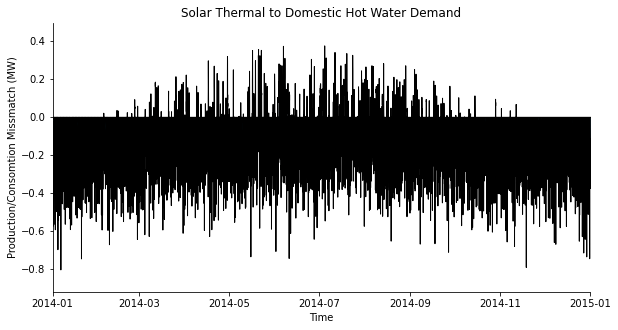

In [23]:
diff1 = st_potential-load_dhw
diff1.hvplot.area(line_width=2,width=800, height=400, xlabel='Time', ylabel= "Production/Consomtion Missmatch (MW)", title = "Solar Thermal to Domestic Hot Water Demand")

### Resampled Data (Daily Resample) for visualization Purposes (reduced noise) ###

In [24]:
diff1 = diff1.resample("D").mean()
x1 = diff1.hvplot.area(line_width=2,width=800, height=400, xlabel='Time', ylabel= "Difference between Production and Consumption (MW)", title = "Solar Thermal to Domestic Hot Water Demand (Resampled Daily Average)")
#hvplot.save(x1 ,"resampled_SolTherm_Load_coverage.png", dpi=400)


### Plotting PV Potential based on Weather Data ###

:Curve   [time]   (LeesteFull)
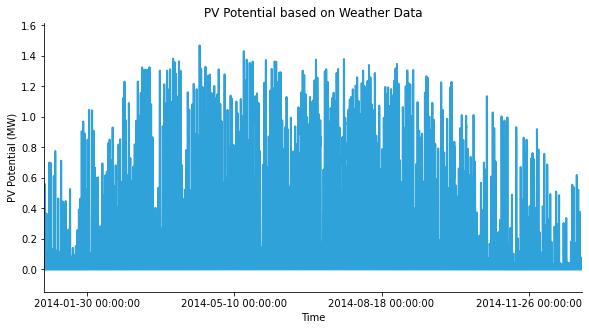

In [25]:
pv.hvplot.line( line_width=2, width=800, height=400, xlabel='Time', ylabel='PV Potential (MW)', title= "PV Potential based on Weather Data", xticks=4)


### Plotting PV powered Heat pump potential ###

In [26]:
HP1 = HP.hvplot.line( line_width=2, width=800, height=400, xlabel='Time', ylabel='Thermal Power Production (MW Therm)', title= "Thermal Power Production of Air Heat Pumps powered by PV",  xticks=4)
#hvplot.save(HP1 ,"HP1pro.png", dpi=400)

### Plotting Simulated hourly load for Space Heating ###

:Curve   [Time/s]   (ABS III_Q_flow_sph/kW)
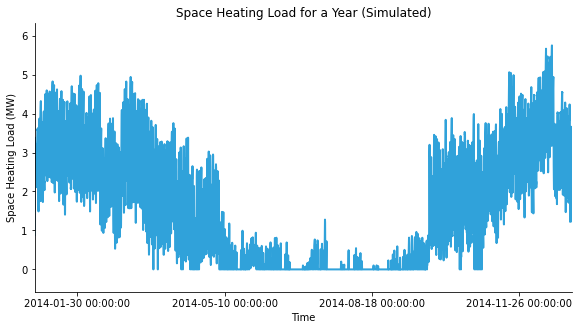

In [27]:
load_sph.hvplot.line( line_width=2,width=800, height=400, xlabel='Time', ylabel='Space Heating Load (MW)',title= "Space Heating Load for a Year (Simulated)",  xticks=4)

### Plotting difference between Heat pump production and space heating demand ###

:Area   [index]   (0)
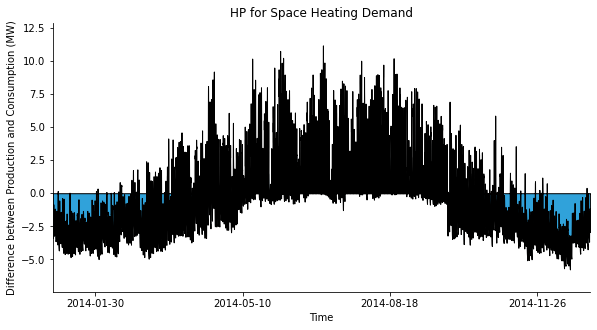

In [28]:
diff2 = HP-load_sph
diff2.hvplot.area(line_width=2,width=800, height=400, xlabel='Time', ylabel= "Difference between Production and Consumption (MW)", title="HP for Space Heating Demand",  xticks=4)

### Plotting Difference betweeen Production and Consumption , Air Heat Pump Production to Space Heating Demand. Resampled Daily average for visualization Purposes ###

In [29]:
diff2 = diff2.resample("D").mean()
x2 = diff2.hvplot.area(width=800, height=400, xlabel='Time', ylabel= "Difference between Production and Consumption (MW)", title="Air Heat Pump Production to Space Heating Demand (Resampled Daily Average)")
#hvplot.save(x2 ,"resampled_HP_Load_coverage.png", dpi=400)


## Sensetivity Analysis ##

### Running the sensitivity Analysis ###

In [30]:
alpha=[0, 0.2, 0.4, 0.6, 0.8, 1]
st_a={}
HP_a={}
demand_cover_dw_a={}
demand_cover_sh_a={}
for a in alpha :
    pv_temp=pv*a
    st_temp = st_potential * (1-a)
    HP_temp= pv_temp*COP
    diff1_temp = st_temp-load_dhw
    diff2_temp = HP_temp-load_sph
    
    overproduction_dw_temp= diff1_temp[diff1_temp > 0]
    overproduction_sh_temp= diff2_temp[diff2_temp > 0]
    st_a[a]= overproduction_dw_temp.sum()
    HP_a[a]= overproduction_sh_temp.sum()

    demand_cover_dw= st_temp.sum()/load_dhw.sum() *100
    demand_cover_sh= HP_temp.sum()/load_sph.sum() *100
    
    demand_cover_dw_a[a]= demand_cover_dw
    demand_cover_sh_a[a]=demand_cover_sh

print(st_a)
print(HP_a)
print(demand_cover_dw_a)
print(demand_cover_sh_a)



{0: 68.91469875077783, 0.2: 36.941179618191, 0.4: 15.067921162624717, 0.6: 3.261125109867904, 0.8: 0.046728540064039, 1: 0.0}
{0: 0.0, 0.2: 1361.3833692706976, 0.4: 2920.4186039886977, 0.6: 4564.750968813228, 0.8: 6265.54102914921, 1: 8004.335351355747}
{0: 26.008799858060417, 0.2: 20.807039886448337, 0.4: 15.605279914836254, 0.6: 10.403519943224168, 0.8: 5.201759971612082, 1: 0.0}
{0: 0.0, 0.2: 14.240861866485377, 0.4: 28.481723732970753, 0.6: 42.72258559945612, 0.8: 56.963447465941506, 1: 71.20430933242687}


### Plotting Sensetivity Analysis ###

### Plotting First Graph of the Sensitivity Analysis ###

In [31]:
keys = list(demand_cover_dw_a.keys())
values1 = list(demand_cover_dw_a.values())
values2 = list(demand_cover_sh_a.values())

# Create pandas DataFrames
df1 = pd.DataFrame({'x': keys, 'y1': values1})
df2 = pd.DataFrame({'x': keys, 'y2': values2})

# Plot using HVplot
plot = df1.hvplot.area(x='x', y='y1', color='blue', alpha=0.5, label='Domestic Hot Water') * \
       df2.hvplot.area(x='x', y='y2', color='red', alpha=0.5, label='Space Heating')

# Customize the plot
plot.opts(xlabel='a', ylabel='Load Coverage [%]', title='Sensitivity Analysis with Capacity Variation', legend_position='top_left', 
          fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12}, show_grid=True)

# Display the plot
plot.opts(width=700, height=400).opts(aspect='square')
#hvplot.save(plot, "SensitivityAnalysis1.pdf", dpi=400)

### Plotting Second Graph of the Sensetivity Analysis ###

In [32]:
keys = list(demand_cover_dw_a.keys())
values3 = list(st_a.values())/load_dhw.sum() *100
values4 = list(HP_a.values())/load_sph.sum() *100 /COP.mean()

# Create pandas DataFrames
df1 = pd.DataFrame({'x': keys, 'y1': values3})
df2 = pd.DataFrame({'x': keys, 'y2': values4})

# Plot using HVplot
plot = df1.hvplot.area(x='x', y='y1', color='blue', alpha=0.5, label='Domestic Hot Water') * \
       df2.hvplot.area(x='x', y='y2', color='red', alpha=0.5, label='PV')

# Customize the plot
plot.opts(xlabel='a', ylabel='Overproduction in relation to yearly demand [%]', title='Sensitivity Analysis with Capacity Variation, Overproduction', legend_position='top_left', 
          fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12}, show_grid=True)

# Display the plot
plot.opts(width=700, height=400).opts(aspect='square')
#hvplot.save(plot, "SensitivityAnalysis2.png", dpi=400)

### Extra: Filtering Irradation Data to evaluate Proper irradation average to use for effiencies of Solar Thermal calculation ###

In [34]:
irradation = pd.read_csv("Irradation.csv")

Gi = irradation["G(i)"]

Gi2 = Gi.dropna()
Gi2 = Gi2.apply(pd.to_numeric, errors='coerce')
print(type(Gi2.loc[0]))
Gi3 = Gi2.loc[(Gi2 != 0)]
Gi4 = Gi2.loc[(Gi2 > 100)]
Gi3 = Gi3.iloc[:-2]
print(Gi3.mean())
print((Gi4.mean()))
print(Gi4)
seconds_offset = (2014 - 1970) * 365.25 * 24 * 3600
Gi4.index = pd.to_datetime(Gi4.index+ seconds_offset, unit='s')

<class 'numpy.float64'>
293.84847018047094
427.3333026040277
10       503.430000
11       286.180000
12       262.470000
13       278.250000
33       253.940000
            ...    
17506    221.660000
17508    535.330000
17509    510.010000
17510    189.150000
17520    140.332771
Name: G(i), Length: 5442, dtype: float64
